In [1]:
import numpy as np
import pandas as pd
#pd.options.display.float_format = '{:2f}'.format

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from io import StringIO
from IPython.display import Image, display
import pydotplus

In [2]:
!ls

 file4k.html	    README.md				   rstate
 img		   'Real estate valuation data set.xlsx'   rstate_functions.py
 price_by_geo.jpg   real_state.ipynb			   tree.png
 __pycache__	    requirements.txt


In [3]:
# Carga de los datos
data = pd.read_excel("Real estate valuation data set.xlsx", parse_dates=['X1 transaction date'])
data['X1 transaction date'] = pd.to_datetime(data['X1 transaction date'])

## Data Preparation

In [4]:
data.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,1970-01-01 00:00:00.000002012,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,1970-01-01 00:00:00.000002012,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,1970-01-01 00:00:00.000002013,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,1970-01-01 00:00:00.000002013,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,1970-01-01 00:00:00.000002012,5.0,390.56840,5,24.97937,121.54245,43.1


In [5]:
# Renaming columns
data.columns = ['no','transaction_date','house_age','distance_to_station','n_stores','latitude','longitude','price']

# Dropping column 'no'
data.drop('no', axis=1, inplace=True)

## Exploratory Data Analysis

In [6]:
# Infromación de los datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   transaction_date     414 non-null    datetime64[ns]
 1   house_age            414 non-null    float64       
 2   distance_to_station  414 non-null    float64       
 3   n_stores             414 non-null    int64         
 4   latitude             414 non-null    float64       
 5   longitude            414 non-null    float64       
 6   price                414 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 22.8 KB


In [7]:
# Valores únicos por variable
data.nunique()

transaction_date         2
house_age              236
distance_to_station    259
n_stores                11
latitude               234
longitude              232
price                  270
dtype: int64

In [8]:
# 'transaction_date' review
print(data['transaction_date'].unique())

# Borrado de la variable "transaction_date"
data.drop('transaction_date', axis=1, inplace=True)

['1970-01-01T00:00:00.000002012' '1970-01-01T00:00:00.000002013']


### Distribution of price

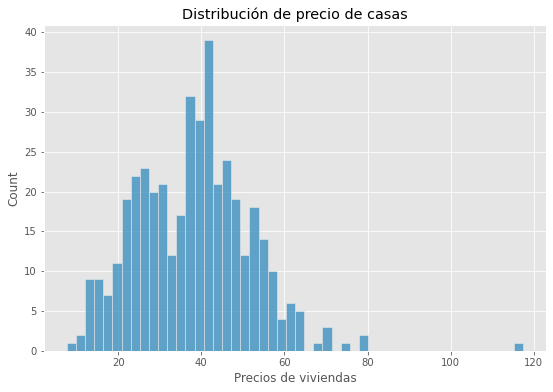

In [9]:
# Distribución de precios
fig, ax =plt.subplots(figsize=(9,6))
plt.title('Distribución de precio de casas')
ax = sns.histplot(data.price, bins=50)
ax.set_xlabel('Precios de viviendas')
plt.show()

In [10]:
# Conversión logarítmica de los precios
def log_transformer(arr):
    return np.log1p(arr)

data['price_log'] = log_transformer(data['price'])

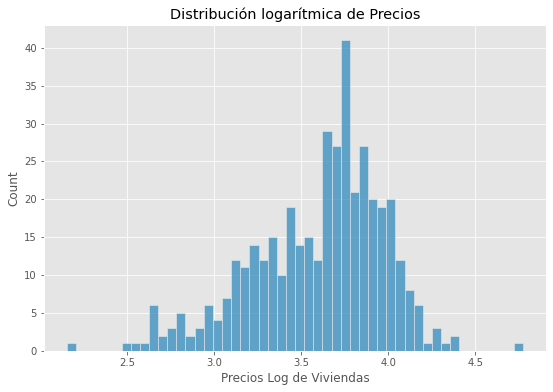

In [11]:
# LogNormal price distribution
fig, ax =plt.subplots(figsize=(9,6))
plt.title('Distribución logarítmica de Precios')
sns.histplot(data['price_log'], bins=50)
ax.set_xlabel('Precios Log de Viviendas')
plt.show()

### Valores Nulos

In [12]:
data.isnull().sum()

house_age              0
distance_to_station    0
n_stores               0
latitude               0
longitude              0
price                  0
price_log              0
dtype: int64

### Visualización de datos geográficos

Contamos con datos geográficos(longitud, latitud). Los visualizamos para buscar patrones.  


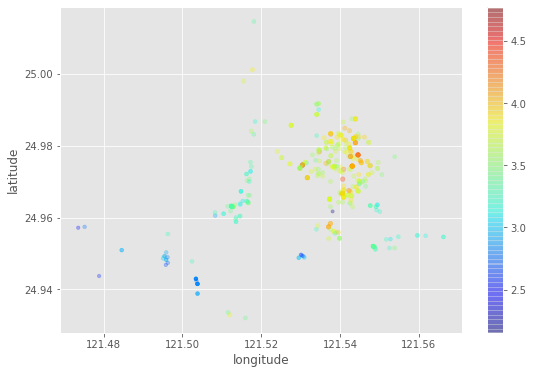

In [13]:
# By price
fig, ax = plt.subplots(1,1)
data.plot(kind='scatter', x='longitude', y='latitude', alpha=.3,
          s=data['price_log']*5,c=data['price_log'], cmap=plt.get_cmap('jet'), colorbar=True,
          ax=ax, figsize=(9,6))
plt.savefig('img/price_by_geo.jpg')

Podemos observar que existe un área donde se concentran una gran cantidad de viviendas con precios medios-altos, sin embargo, en esta área se puede observar que hay instancias con valores bajos. Las vivivendas de precios más bajos, se encuentran dispersas, por lo general, alejadas del área anteriormente mencionada. 

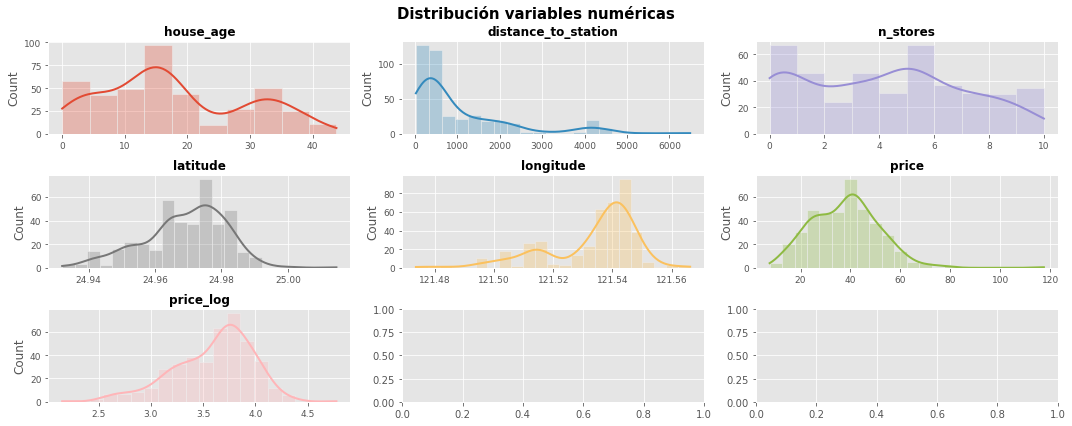

In [14]:
import rstate_functions
rstate_functions.distPlotter(data)

### Correlaciones

In [15]:
# Matriz de correlación - Rangos de Spearman
corr_matrix = data.corr(method='spearman')
# Correlaciones con respecto al precio de viviendas
corr_matrix['price_log'].sort_values()

distance_to_station   -0.775948
house_age             -0.281753
longitude              0.437672
latitude               0.578419
n_stores               0.617333
price                  1.000000
price_log              1.000000
Name: price_log, dtype: float64

In [16]:
data.columns

Index(['house_age', 'distance_to_station', 'n_stores', 'latitude', 'longitude',
       'price', 'price_log'],
      dtype='object')

## <b>Modelo

In [17]:
# División de los datos en datos de entrenamiento y prueba
# 80% datos de entrenamiento              
# 20% datos de prueba
features = ['house_age', 'distance_to_station', 'n_stores', 'latitude', 'longitude']
X = data[features]
y = data['price_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=.2)

In [18]:
# Standarizador de datos
standarizer = Pipeline([('standarizer', StandardScaler())])

# Datos de entrada al modelo
# ================================================================
X_pred = standarizer.fit_transform(X_train)

### Randon Forest (Bosque Aleatorio)

Algoritmo de Bosque Aleatorio (Regresión) con parámetros por defecto.

In [19]:
# Regresor de Bosque Aleatorio
# Entrenamiento del modelo
# =====================================================================
rf_reg = RandomForestRegressor(random_state=0)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [20]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X.columns,
                             'importancia': rf_reg.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
1,distance_to_station,0.636690
0,house_age,0.135176
3,latitude,0.127845
4,longitude,0.084148
2,n_stores,0.016141


### Cross_validation (Validación Cruzada) - 10 k-folds

In [21]:
# Validación cruzada de 10 plieges
# =====================================================================
y_preds = cross_val_score(rf_reg, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)
rf_rmse = np.sqrt(-y_preds)
print('RMSE de los 10 k-folds:')
print(rf_rmse)
print()
rf_rmse_mean = round(np.mean(rf_rmse),2)
rf_rmse_std = round(np.std(rf_rmse),2)
print(f'RMSE: {rf_rmse_mean}, desviación: {rf_rmse_std}')

RMSE de los 10 k-folds:
[0.1503749  0.13613783 0.27177529 0.16164595 0.28642388 0.19267162
 0.15067305 0.19745162 0.16546155 0.20453683]

RMSE: 0.19, desviación: 0.05


### Ajuste del modelo

In [22]:
# Parámetros del modelo - Random Forest
rf_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [23]:
# Hiperparámetros - RandomForest
# ==========================================================================

# Método de selección de muestra
bootstrap = [True, False]
# Niveles máximos en cada árbol
max_depth = [x for x in np.arange(10, 150, step=10)]
# Cantidad de características a considerar para cada división
max_features = ['auto', 'sqrt']
# Cantidad mínima de muestras requeridas para un nodo hoja
min_samples_leaf = [x for x in np.arange(0, 30, step=5)]
# Cantidad mínimas de muestras para dividir un nodo
min_samples_split = [x for x in np.arange(0, 30, step=5)]
# Cantidad de árboles
n_estimators = [x for x in np.arange(30, 500, step=25)]

param_distributions = {
    'bootstrap'         : bootstrap,
    'max_depth'         : max_depth,
    'max_features'      : max_features,
    'min_samples_leaf'  : min_samples_leaf,
    'min_samples_split' : min_samples_split,
    'n_estimators'      : n_estimators,
}

# Búsqueda aleatoria de hiperparámetros
rf_random_search = RandomizedSearchCV(estimator=rf_reg, 
                        param_distributions=param_distributions,
                        scoring='neg_mean_squared_error',
                        cv=10, 
                        n_jobs=-1, 
                        random_state=40)    

rf_random_search.fit(X_train, y_train)

/home/pablo/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pablo/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/pablo/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/pablo/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/pablo/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = sel

/home/pablo/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pablo/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/pablo/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/pablo/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/pablo/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = sel

/home/pablo/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pablo/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pablo/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/pablo/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/pablo/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/pablo/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = sel

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=0),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [0, 5, 10, 15, 20,
                                                             25],
                                        'min_samples_split': [0, 5, 10, 15, 20,
                                                              25],
                                        'n_estimators': [30, 55, 80, 105, 130,
                                                         155, 180, 205, 230,
                                                         255, 280, 305, 330,
    

In [24]:
rf_random_search.best_params_

{'n_estimators': 330,
 'min_samples_split': 15,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [25]:
def evaluate(model, X_train, y_train):
    y_preds = cross_val_score(rf_reg, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)
    scores = np.sqrt(-y_preds)
    model_score = np.mean(scores)
    print('Model Performance')
    print('Root Mean Squared Error: {:0.4f}'.format(model_score))
    
    return model_score

In [26]:
#base_model.fit(X_train, y_train)
base_rmse = evaluate(rf_reg, X_train, y_train)

Model Performance
Root Mean Squared Error: 0.1917


In [27]:
best_random = rf_random_search.best_estimator_
random_rmse = evaluate(rf_random_search, X_train, y_train)

Model Performance
Root Mean Squared Error: 0.1917


#### GridSearchCV

In [28]:
rf_random_search.best_params_

{'n_estimators': 330,
 'min_samples_split': 15,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [29]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators':      [328, 330, 332],
    'min_samples_split': [13, 15, 17],
    'min_samples_leaf':  [3, 5, 7],
    'max_features':      ['sqrt'],
    'max_depth':         [28, 30, 32],
    'bootstrap':         [True]
}

# Create a based model
rf_grid_search = RandomForestRegressor(random_state=332)

# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf_grid_search, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [30]:
# Fit the grid search to the data
rf_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=13, n_estimators=330; total time=   0.8s
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=13, n_estimators=330; total time=   0.8s
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=13, n_estimators=332; total time=   0.8s
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=15, n_estimators=330; total time=   0.8s
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=15, n_estimators=332; total time=   0.8s
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=17, n_estimators=330; total time=   0.8s
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=17, n_estimators=332

[CV] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=7, min_samples_split=17, n_estimators=330; total time=   0.8s[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=13, n_estimators=328; total time=   0.8s
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=13, n_estimators=332; total time=   0.8s
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=15, n_estimators=328; total time=   0.8s
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=15, n_estimators=330; total time=   0.8s
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=17, n_estimators=328; total time=   0.8s
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=17, n_estimators=328; total time=   0.8s
[CV] END bootstrap=True, max_depth=28, max

[CV] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=7, min_samples_split=17, n_estimators=330; total time=   0.8s[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=13, n_estimators=328; total time=   0.9s
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=13, n_estimators=332; total time=   0.8s
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=15, n_estimators=328; total time=   0.8s
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=15, n_estimators=332; total time=   0.8s
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=17, n_estimators=328; total time=   0.8s
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=17, n_estimators=330; total time=   0.8s
[CV] END bootstrap=True, max_depth=28, max

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=332), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [28, 30, 32],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [13, 15, 17],
                         'n_estimators': [328, 330, 332]},
             verbose=2)

In [31]:
rf_grid_search.best_params_

{'bootstrap': True,
 'max_depth': 28,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 13,
 'n_estimators': 328}

In [32]:
rf_grid_search_rmse = evaluate(rf_grid_search, X_train, y_train)

Model Performance
Root Mean Squared Error: 0.1917


### Evaluate

In [33]:
# Modelo final 
final_model = rf_grid_search.best_estimator_
# Preparación de los datos de prueba
X_test_prepared = standarizer.transform(X_test)

In [34]:
# Predicción de los datos de prueba
final_predictions = final_model.predict(X_test_prepared)

In [35]:
# Evaluacion del modelo con los datos de prueba
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
final_rmse

0.3643697147444518